# Collaborative Filtering

The technique we're going to take a look at is Collaborative filtering.It is based on the fact that relationships exist between products and people's interests. Many recommendation systems use collaborative filtering to find these relationships and to give an accurate recommendation of a product that the user might like or be interested in.


As hinted by its alternate name, this technique uses other users to recommend items to the input user.

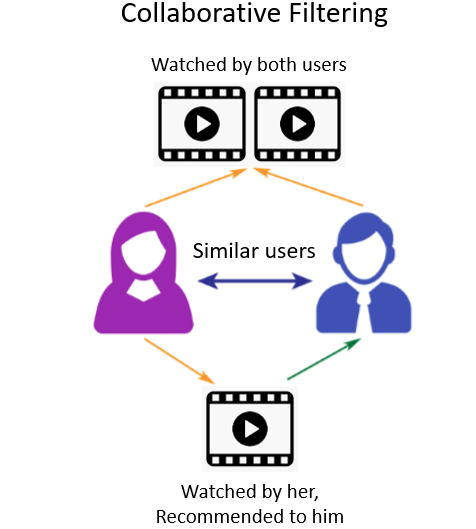

### Dataset

This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 

## Preprocessing


In [1]:
import pandas as pd
from math import sqrt
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
movies_df = pd.read_csv(r'C:\Users\P Sai Deekshith\Recommender Systems\ml-100k\movies.csv')

ratings_df = pd.read_csv(r'C:\Users\P Sai Deekshith\Recommender Systems\ml-100k\ratings.csv')


In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Extract the year from Title column to a separate column:

In [5]:
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())

movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


Splitting the genre:

In [6]:
movies_df = movies_df.drop('genres', 1)
movies_df.head()

,movieId,title,year
0,1,Toy Story,1995
1,2,Jumanji,1995
2,3,Grumpier Old Men,1995
3,4,Waiting to Exhale,1995
4,5,Father of the Bride Part II,1995


In [7]:
ratings_df = ratings_df.drop('timestamp', 1)
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### User Based Recommendation System

User-Based Collaborative Filtering is a technique used to predict the items that a user might like on the basis of ratings given to that item by the other users who have similar taste with that of the target user.

The process for creating a User Based recommendation system is as follows:

-   Select a user with the movies the user has watched
-   Based on his rating to movies, find the top X neighbours 
-   Get the watched movie record of the user for each neighbour.
-   Calculate a similarity score using some formula
-   Recommend the items with the highest score

#### User Input

In [8]:
userInput = [
            {'title':'Grumpier Old Men', 'rating':3.180094},
            {'title':'Toy Story', 'rating':3.894802},
            {'title':'Jumanji', 'rating':3.221086},
            {'title':'Waiting to Exhale', 'rating':2.879727},
            {'title':'Father of the Bride Part II', 'rating':3.080811}
            ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,Grumpier Old Men,3.180094
1,Toy Story,3.894802
2,Jumanji,3.221086
3,Waiting to Exhale,2.879727
4,Father of the Bride Part II,3.080811


#### Add movieId to input user

With the input complete, let's extract the input movies's ID's from the movies dataframe and add them into it.

We can achieve this by first filtering out the rows that contain the input movies' title and then merging this subset with the input dataframe.

In [9]:
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
inputMovies = pd.merge(inputId, inputMovies)
inputMovies = inputMovies.drop('year', 1)

inputMovies

,movieId,title,rating
0,1,Toy Story,3.894802
1,2,Jumanji,3.221086
2,3,Grumpier Old Men,3.180094
3,4,Waiting to Exhale,2.879727
4,5,Father of the Bride Part II,3.080811


#### The users who has rated the same movies

Now with the movie ID's in our input, we can now get the subset of users that have watched and reviewed the movies in our input.


In [10]:
userSubset = ratings_df[ratings_df['movieId'].isin(inputMovies['movieId'].tolist())]
userSubset.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
516,5,1,4.0
560,6,2,4.0
561,6,3,5.0


We now group up the rows by user ID.


In [11]:
userSubsetGroup = userSubset.groupby(['userId'])

e.g. the one with userID=1


In [12]:
userSubsetGroup.get_group(1)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0


Let's also sort these groups so the users that share the most movies in common with the input have higher priority which provides a richer recommendation since we won't go through every single user.


In [13]:
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

In [14]:
userSubsetGroup[0:3]

[(6,
       userId  movieId  rating
  560       6        2     4.0
  561       6        3     5.0
  562       6        4     3.0
  563       6        5     5.0),
 (68,
         userId  movieId  rating
  10360      68        1     2.5
  10361      68        2     2.5
  10362      68        3     2.0
  10363      68        5     2.0),
 (169,
         userId  movieId  rating
  24321     169        1     4.5
  24322     169        2     4.0
  24323     169        3     5.0
  24324     169        5     5.0)]

#### Similarity of users to input user

Next, we are going to compare all users to our specified user and find the one that is most similar.  
we're going to find out how similar each user is to the input through the **Pearson Correlation Coefficient**. It is used to measure the strength of a linear association between two variables. The formula for finding this coefficient between sets X and Y with N values can be seen in the image below. 

Why Pearson Correlation?

Pearson correlation is invariant to scaling, i.e. multiplying all elements by a nonzero constant or adding any constant to all elements. For example, if you have two vectors X and Y,then, pearson(X, Y) == pearson(X, 2 * Y + 3). This is a pretty important property in recommendation systems because for example two users might rate two series of items totally different in terms of absolute rates, but they would be similar users (i.e. with similar ideas) with similar rates in various scales .

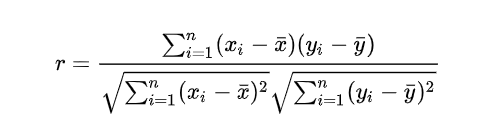

The values given by the formula vary from r = -1 to r = 1, where 1 forms a direct correlation between the two entities (it means a perfect positive correlation) and -1 forms a perfect negative correlation. 


In our case, a 1 means that the two users have similar tastes while a -1 means the opposite.


We will select a subset of users to iterate through. This limit is imposed because we don't want to waste too much time going through every single user.


In [15]:
userSubsetGroup = userSubsetGroup[0:100]

In [16]:
pearsonCorrelationDict = {}

for name, group in userSubsetGroup:
    group = group.sort_values(by='movieId')
    inputMovies = inputMovies.sort_values(by='movieId')
    nRatings = len(group)
    temp_df = inputMovies[inputMovies['movieId'].isin(group['movieId'].tolist())]
    tempRatingList = temp_df['rating'].tolist()
    tempGroupList = group['rating'].tolist()
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0


In [17]:
pearsonCorrelationDict.items()

dict_items([(6, 0.6645840897002872), (68, 0.6638961948535128), (169, -0.2850502270499941), (288, 0.7147918449964106), (414, 0.6086169331328474), (448, 0.9873729583510551), (470, 0.9873729583510488), (590, 0.9193443069451127), (600, 0.2332229680444361), (19, 0.998695048103195), (43, 0), (91, 0.998695048103195), (103, 0), (107, -0.35387773460750416), (117, 0), (217, 0.9603948798074232), (226, 0.4551191319193728), (240, 0.5435759161838064), (269, 0.9164899615161637), (270, 0.9937324309318302), (276, 0.633047497835676), (307, 0.7215089732579152), (321, 0.7254797973130575), (330, 0.7714671836904431), (337, 0), (353, 0.9352916919063572), (411, 0.9297888148534273), (456, 0.9937324309318302), (474, 0.8885255218253485), (477, 0.5435759161838093), (480, 0.5435759161838064), (483, 0.6330474978356796), (492, 0.5936747470410121), (501, 0.23329642386741364), (561, 0.633047497835676), (599, 0.78837601695509), (604, -0.35387773460751076), (608, 0.998695048103195), (1, 0), (18, 0.9999999999999967), (21

In [18]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()


,similarityIndex,userId
0,0.664584,6
1,0.663896,68
2,-0.285050,169
3,0.714792,288
4,0.608617,414


#### The top x similar users to input user

Now let's get the top 50 users that are most similar to the input.


In [19]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,userId
46,1.0,51
72,1.0,294
75,1.0,308
92,1.0,489
89,1.0,458


Now, let's start recommending movies to the input user.

#### Rating of selected users to all movies

We're going to do this by taking the weighted average of the ratings of the movies using the Pearson Correlation as the weight. But to do this, we first need to get the movies watched by the users in our pearsonDF from the ratings dataframe and then store their correlation in a new column called similarityIndex. This is achieved below by merging of these two tables.


In [20]:
topUsersRating=topUsers.merge(ratings_df, left_on='userId', right_on='userId', how='inner')
topUsersRating.head()

,similarityIndex,userId,movieId,rating
0,1.0,51,2,4.5
1,1.0,51,3,4.0
2,1.0,51,7,4.0
3,1.0,51,36,3.0
4,1.0,51,65,3.5


Now all we need to do is simply multiply the movie rating by its weight (The similarity index), then sum up the new ratings and divide it by the sum of the weights.


We can easily do this by simply multiplying two columns, then grouping up the dataframe by movieId

In [21]:
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

,similarityIndex,userId,movieId,rating,weightedRating
0,1.0,51,2,4.5,4.5
1,1.0,51,3,4.0,4.0
2,1.0,51,7,4.0,4.0
3,1.0,51,36,3.0,3.0
4,1.0,51,65,3.5,3.5


In [22]:
tempTopUsersRating = topUsersRating.groupby('movieId').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
movieId,,
1,42.504275,177.844486
2,35.325800,103.747743
3,18.476149,50.318434
4,0.929789,1.859578
5,19.062134,50.219477


In [23]:
recommendation_df = pd.DataFrame()

recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['movieId'] = tempTopUsersRating.index
recommendation_df.head()

,weighted average recommendation score,movieId
movieId,,
1,4.184155,1
2,2.936883,2
3,2.723427,3
4,2.000000,4
5,2.634515,5


In [24]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(10)

,weighted average recommendation score,movieId
movieId,,
3814,5.0,3814
8580,5.0,8580
2295,5.0,2295
1999,5.0,1999
71268,5.0,71268
74282,5.0,74282
77846,5.0,77846
2771,5.0,2771
5915,5.0,5915


In [25]:
movies_df.loc[movies_df['movieId'].isin(recommendation_df.head(10)['movieId'].tolist())]

,movieId,title,year
1474,1999,"Exorcist III, The",1990
1707,2295,"Impostors, The",1998
2085,2771,Brokedown Palace,1999
2852,3814,Love and Death,1975
4121,5915,Victory (a.k.a. Escape to Victory),1981
5236,8580,Into the Woods,1991
6022,38304,No Direction Home: Bob Dylan,2005
7134,71268,Tyler Perry's I Can Do Bad All by Myself,2009
7252,74282,Anne of Green Gables: The Sequel (a.k.a. Anne ...,1987
7332,77846,12 Angry Men,1997


### Evaluation

We use RMSE(Root Mean Square Error) to evaluate the recommendations.

Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

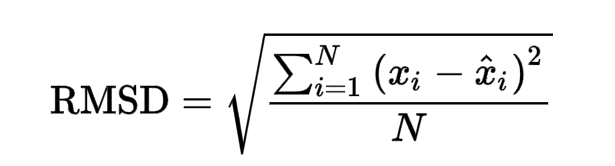

In [26]:
recommendation_df.head()

,weighted average recommendation score,movieId
movieId,,
3814,5.0,3814
8580,5.0,8580
2295,5.0,2295
1999,5.0,1999
71268,5.0,71268


In [27]:
rec_df = recommendation_df[['weighted average recommendation score', 'movieId']]
rec_df.reset_index(drop=True, inplace=True)
recommendedMovieId = rec_df['movieId']
rec_df.head()

,weighted average recommendation score,movieId
0,5.0,3814
1,5.0,8580
2,5.0,2295
3,5.0,1999
4,5.0,71268


In [28]:
true_ratings = ratings_df.groupby(ratings_df['movieId']).mean()
true_ratings.drop('userId', axis=1, inplace=True)
true_ratings.head()


,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


In [29]:
true_ratings['movieId'] = true_ratings.index
true_ratings.reset_index(drop=True, inplace=True)
true_ratings = true_ratings[true_ratings.movieId.isin(recommendedMovieId)]

true_ratings.head()

,rating,movieId
0,3.920930,1
1,3.431818,2
2,3.259615,3
3,2.357143,4
4,3.071429,5


In [30]:
true_ratings = pd.DataFrame(true_ratings)
true_ratings.reset_index(drop=True, inplace=True)
true_ratings.head()

,rating,movieId
0,3.920930,1
1,3.431818,2
2,3.259615,3
3,2.357143,4
4,3.071429,5


In [34]:
rec_df = rec_df.sort_values('movieId')
rec_df.reset_index(drop=True, inplace=True)
rec_df['true_ratings'] = true_ratings['rating']
rec_df.head()

,weighted average recommendation score,movieId,true_ratings
0,4.184155,1,3.920930
1,2.936883,2,3.431818
2,2.723427,3,3.259615
3,2.000000,4,2.357143
4,2.634515,5,3.071429


In [37]:
rec_df = rec_df[rec_df.movieId.isin(inputMovies.movieId)]
def rmseUserBased():
    rmse = sqrt(mean_squared_error(rec_df['true_ratings'], rec_df['weighted average recommendation score']))
    print("The RMSE value is : " + str(rmse))
    return rmse

In [38]:
rmseUserBased()

The RMSE value is : 0.42899678300297944


0.42899678300297944

### Advantages and Disadvantages of Collaborative Filtering

##### Advantages

-   Takes other user's ratings into consideration
-   Doesn't need to study or extract information from the recommended item
-   Adapts to the user's interests which might change over time

##### Disadvantages

-   Approximation function can be slow
-   There might be a low of amount of users to approximate
-   Privacy issues when trying to learn the user's preferences
